# Generating random sets for simulation a quantum state

output: random number to be used as qubit values for the tomography part of the experiment

In [1]:
import numpy as np


def get_rand(count):
    return [1 if i > 0.5 else 0 for i in np.random.random(count)]


np.random.seed(1234)

random_set1 = get_rand(10)
random_set2 = get_rand(25)
random_set3 = get_rand(50)



In [2]:
print("Set 1")
print(random_set1)
print("Set 2")
print(random_set2)
print("Set 3")
print(random_set3)


Set 1
[0, 1, 0, 1, 1, 0, 0, 1, 1, 1]
Set 2
[0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1]
Set 3
[1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1]


output: random number to be used as qubit values for the bell test part of the experiment

In [3]:
np.random.seed(1235)
rands = [get_rand(20) for i in range(22)]
for i, r in enumerate(rands):
    print(f"Set number {i + 1}")
    print(r)

Set number 1
[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1]
Set number 2
[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1]
Set number 3
[1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]
Set number 4
[1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0]
Set number 5
[1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
Set number 6
[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Set number 7
[0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0]
Set number 8
[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Set number 9
[0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0]
Set number 10
[0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0]
Set number 11
[0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0]
Set number 12
[1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0]
Set number 13
[1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
Set number 14
[0, 1, 0, 0, 1, 1, 0

In [300]:
import enum

class Sensor(enum.Enum):
    V_ALICE = "Alice - V"
    V_BOB = "Bob - V"
    H_ALICE = "Alice - H"
    H_BOB = "Bob - H"


# Processing red light from recorded videos
input: recording of experiment

output: mapping between red light intensity to frame number for each video

In [302]:
import os
import glob

import cv2
import tqdm

RECTS = {
    Sensor.V_ALICE: np.array([496, 51, 331, 256]),
    Sensor.V_BOB: np.array([489, 422, 331, 241]),
    Sensor.H_ALICE: np.array([926, 61, 332, 248]),
    Sensor.H_BOB: np.array([928, 427, 328, 250]),
}


# calculates the red pixels intensity, by summing the intensity or red pixles
def calculate_red_intensity(frame, box):
    x, y, w, h = box
    roi = frame[y:y + h, x:x + w]

    red_channel = roi[:, :, 2]
    green_channel = roi[:, :, 1]
    blue_channel = roi[:, :, 0]

    # Consider red-dominant pixels only, using this arbitrary condition
    red_dominant = (red_channel / 1.5 > green_channel) & (red_channel / 1.5 > blue_channel)

    return np.sum([np.linalg.norm([red, green, blue]) for red, green, blue in
                   zip(red_channel[red_dominant], green_channel[red_dominant], blue_channel[red_dominant])])


video_directory = "data"

videos = [f for f in glob.glob(f"{video_directory}/*.mp4")]

intensities = {}

for video in tqdm.tqdm(videos):
    cap = cv2.VideoCapture(video)

    if not cap.isOpened():
        print(f"Unable to open video: {video}")
        continue

    file_name = os.path.basename(video).split(".")[0]
    current_intensities = {}
    intensities[file_name] = current_intensities
    while True:

        ret, frame = cap.read()
        if not ret:
            break

        for r in Sensor:
            if r not in current_intensities:
                current_intensities[r] = []
            intensity = calculate_red_intensity(frame, RECTS[r])
            current_intensities[r].append(intensity)
    cap.release()




100%|██████████| 19/19 [04:55<00:00, 15.56s/it]


# Finding peaks - Tomography
input: red light intensity for each of the first part videos

output: generate graphs and find peaks that are above a preconfigured threshold

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


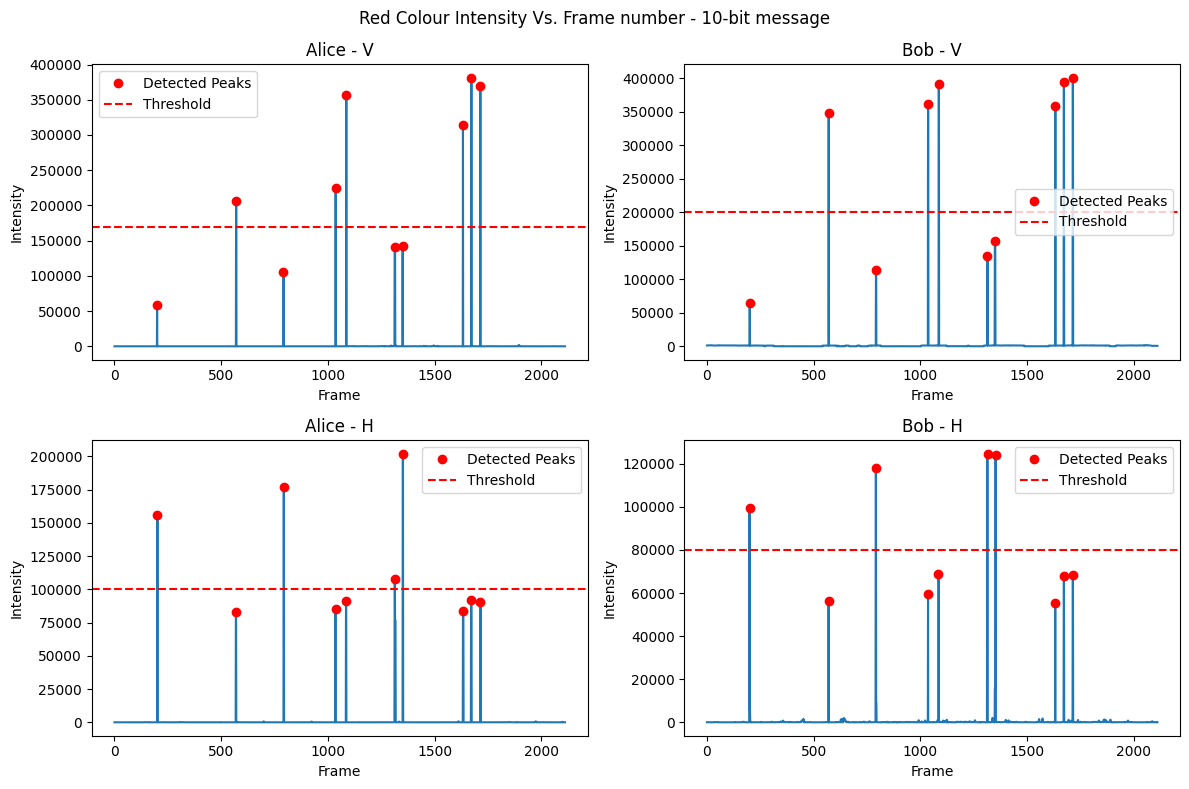

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


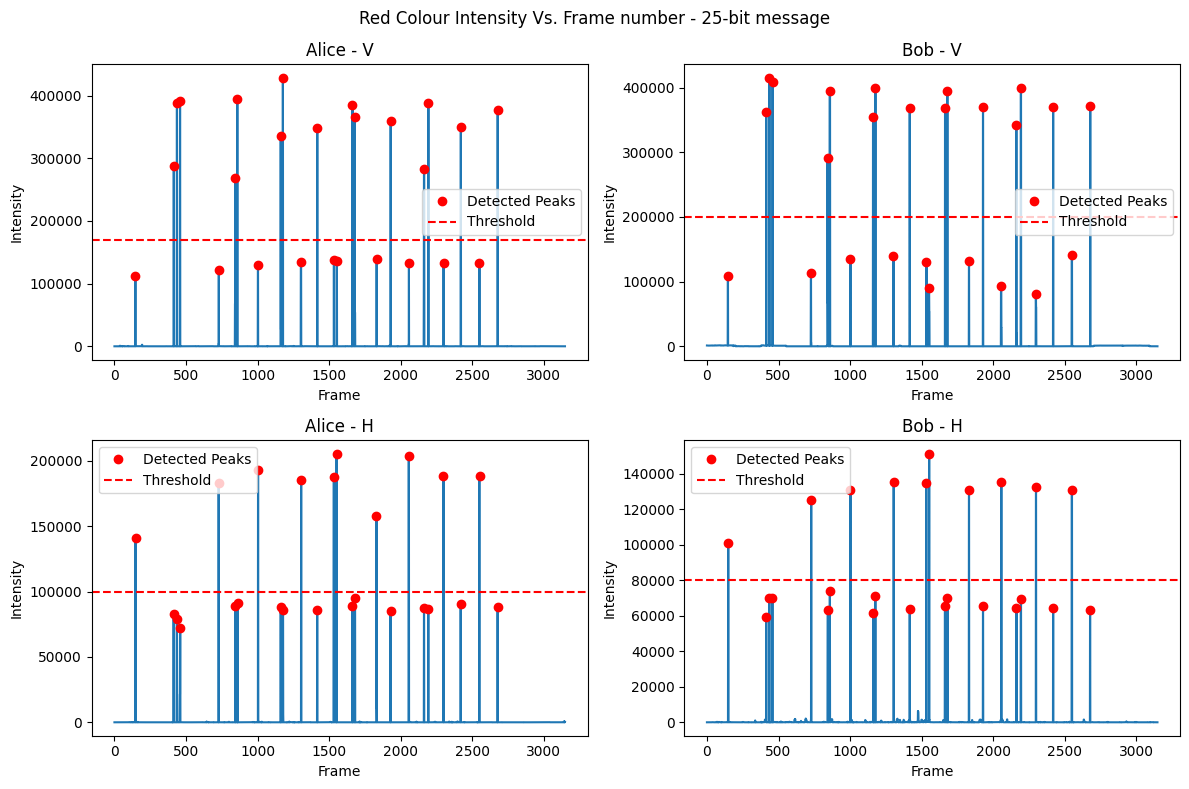

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


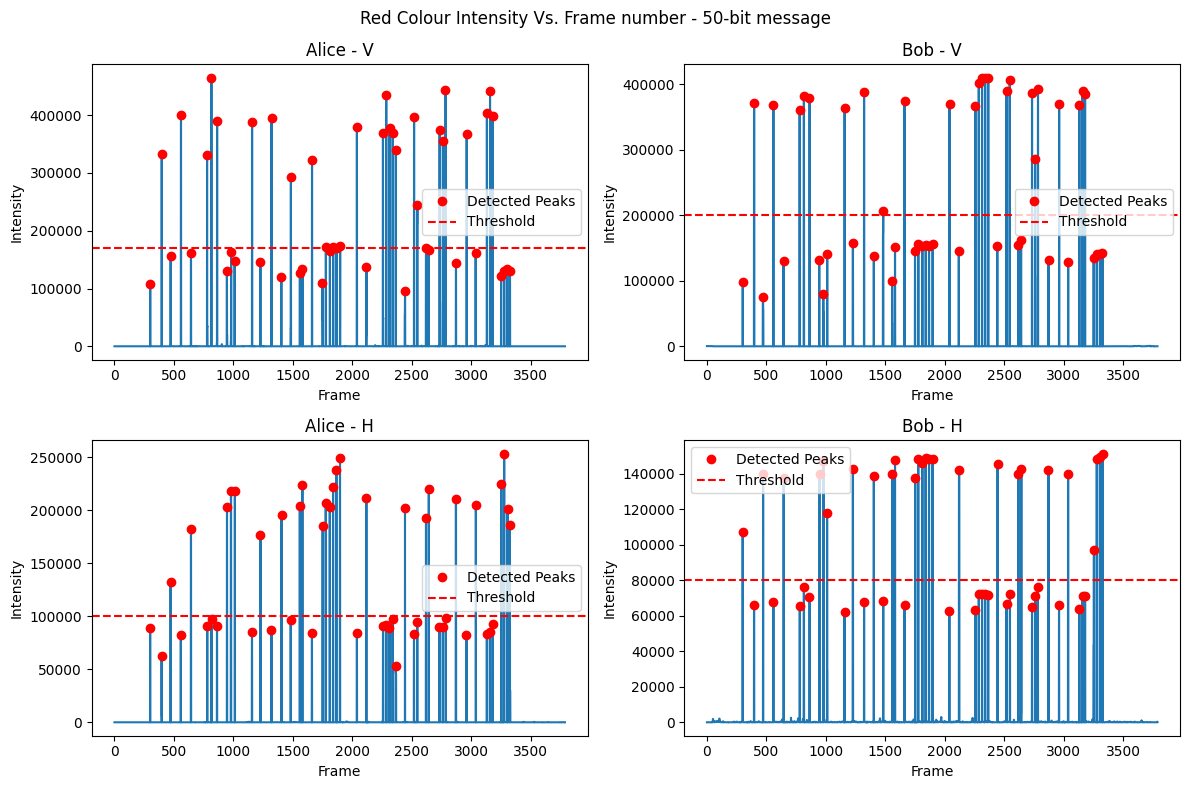

In [371]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np

SENSOR_TO_THRESHOLD = {
    Sensor.V_ALICE: 170000,
    Sensor.V_BOB: 200000,
    Sensor.H_ALICE: 100000,
    Sensor.H_BOB: 80000,
}

exps = {}
exp_peaks_location = {}

file_name_to_pretty_name = {
    "set_of_10": "10-bit message",
    "set_of_25": "25-bit message",
    "set_of_50": "50-bit message",
}

for file_name, current_intensities in intensities.items():
    if "bell" in file_name:
        continue

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f"Red Colour Intensity Vs. Frame number - {file_name_to_pretty_name[file_name]}")

    sensor_to_data = {}
    sensor_to_peaks_location = {}

    sensor_list = list(current_intensities.keys())
    for idx, sensor in enumerate(sensor_list):
        row, col = divmod(idx, 2)
        ax = axes[row, col]

        values = current_intensities[sensor]
        peaks, _ = sp.signal.find_peaks(values, prominence=10000, width=(None, 10), distance=5)
        sensor_to_peaks_location[sensor] = peaks
        peak_values = np.array(values)[peaks]
        threshold = SENSOR_TO_THRESHOLD[sensor]
        sensor_to_data[sensor] = [int(peak > threshold) for peak in peak_values]

        ax.plot(np.arange(len(values)), values)
        ax.plot(np.arange(len(values))[peaks], np.array(values)[peaks], "ro", label="Detected Peaks")
        ax.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
        ax.set_title(f"{sensor.value}")
        ax.set_xlabel("Frame")
        ax.set_ylabel("Intensity")
        ax.legend()
    fig.tight_layout()
    fig.savefig(f"./{file_name}.eps") 

    plt.tight_layout()
    plt.show()
    exps[file_name] = sensor_to_data
    exp_peaks_location[file_name] = sensor_to_peaks_location


# Reconstructing density matrix from experiment
input: peaks found previously

output: reconstructed density matrix

In [367]:
from uncertainties.unumpy import uarray

set_of_10_exp = exps["set_of_10"]
set_of_25_exp = exps["set_of_25"]
set_of_50_exp = exps["set_of_50"]


def bmatrix(a):
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv += [r'\end{bmatrix}']
    return '\n'.join(rv)


def get_density_matrix(sent_data, exp):
    counts = np.zeros((4, 4), dtype=int)
    for i, current_bit in enumerate(sent_data):
        row = 3 if current_bit else 0
        if exp[Sensor.V_BOB][i] and exp[Sensor.V_ALICE][i]:
            col = 0
        elif exp[Sensor.H_BOB][i] and exp[Sensor.V_ALICE][i]:
            col = 1
        elif exp[Sensor.V_BOB][i] and exp[Sensor.H_ALICE][i]:
            col = 2
        elif exp[Sensor.H_BOB][i] and exp[Sensor.H_ALICE][i]:
            col = 3
        else:
            print(i)
            print("undefined state")
            continue
        counts[row][col] += 1
    counts_with_error = uarray(counts, np.sqrt(counts))
    return counts_with_error / len(sent_data)


# assuming this is the first bell state, we can use symmetry to calculate the off diagonal element
def calculate_off_diagonal(mat):
    return mat + np.flipud(mat)


print(bmatrix(calculate_off_diagonal(get_density_matrix(random_set1, set_of_10_exp))))
print(bmatrix(calculate_off_diagonal(get_density_matrix(random_set2, set_of_25_exp))))
print(bmatrix(calculate_off_diagonal(get_density_matrix(random_set3, set_of_50_exp))))





\begin{bmatrix}
  0.6+/-0.2449489742783178 & 0.0+/-0 & 0.0+/-0 & 0.4+/-0.2\\
  0.0+/-0 & 0.0+/-0 & 0.0+/-0 & 0.0+/-0\\
  0.0+/-0 & 0.0+/-0 & 0.0+/-0 & 0.0+/-0\\
  0.6+/-0.2449489742783178 & 0.0+/-0 & 0.0+/-0 & 0.4+/-0.2\\
\end{bmatrix}
\begin{bmatrix}
  0.6+/-0.15491933384829668 & 0.0+/-0 & 0.0+/-0 & 0.4+/-0.1264911064067352\\
  0.0+/-0 & 0.0+/-0 & 0.0+/-0 & 0.0+/-0\\
  0.0+/-0 & 0.0+/-0 & 0.0+/-0 & 0.0+/-0\\
  0.6+/-0.15491933384829668 & 0.0+/-0 & 0.0+/-0 & 0.4+/-0.1264911064067352\\
\end{bmatrix}
0
undefined state
\begin{bmatrix}
  0.48+/-0.09797958971132711 & 0.08+/-0.04 & 0.0+/-0\\
  0.42+/-0.0916515138991168\\
  0.0+/-0 & 0.0+/-0 & 0.0+/-0 & 0.0+/-0\\
  0.0+/-0 & 0.0+/-0 & 0.0+/-0 & 0.0+/-0\\
  0.48+/-0.09797958971132711 & 0.08+/-0.04 & 0.0+/-0\\
  0.42+/-0.0916515138991168\\
\end{bmatrix}


# Finding peaks - Bell
input: red light intensity for each of the second part videos

output: generate graphs and find peaks that are above a preconfigured threshold


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


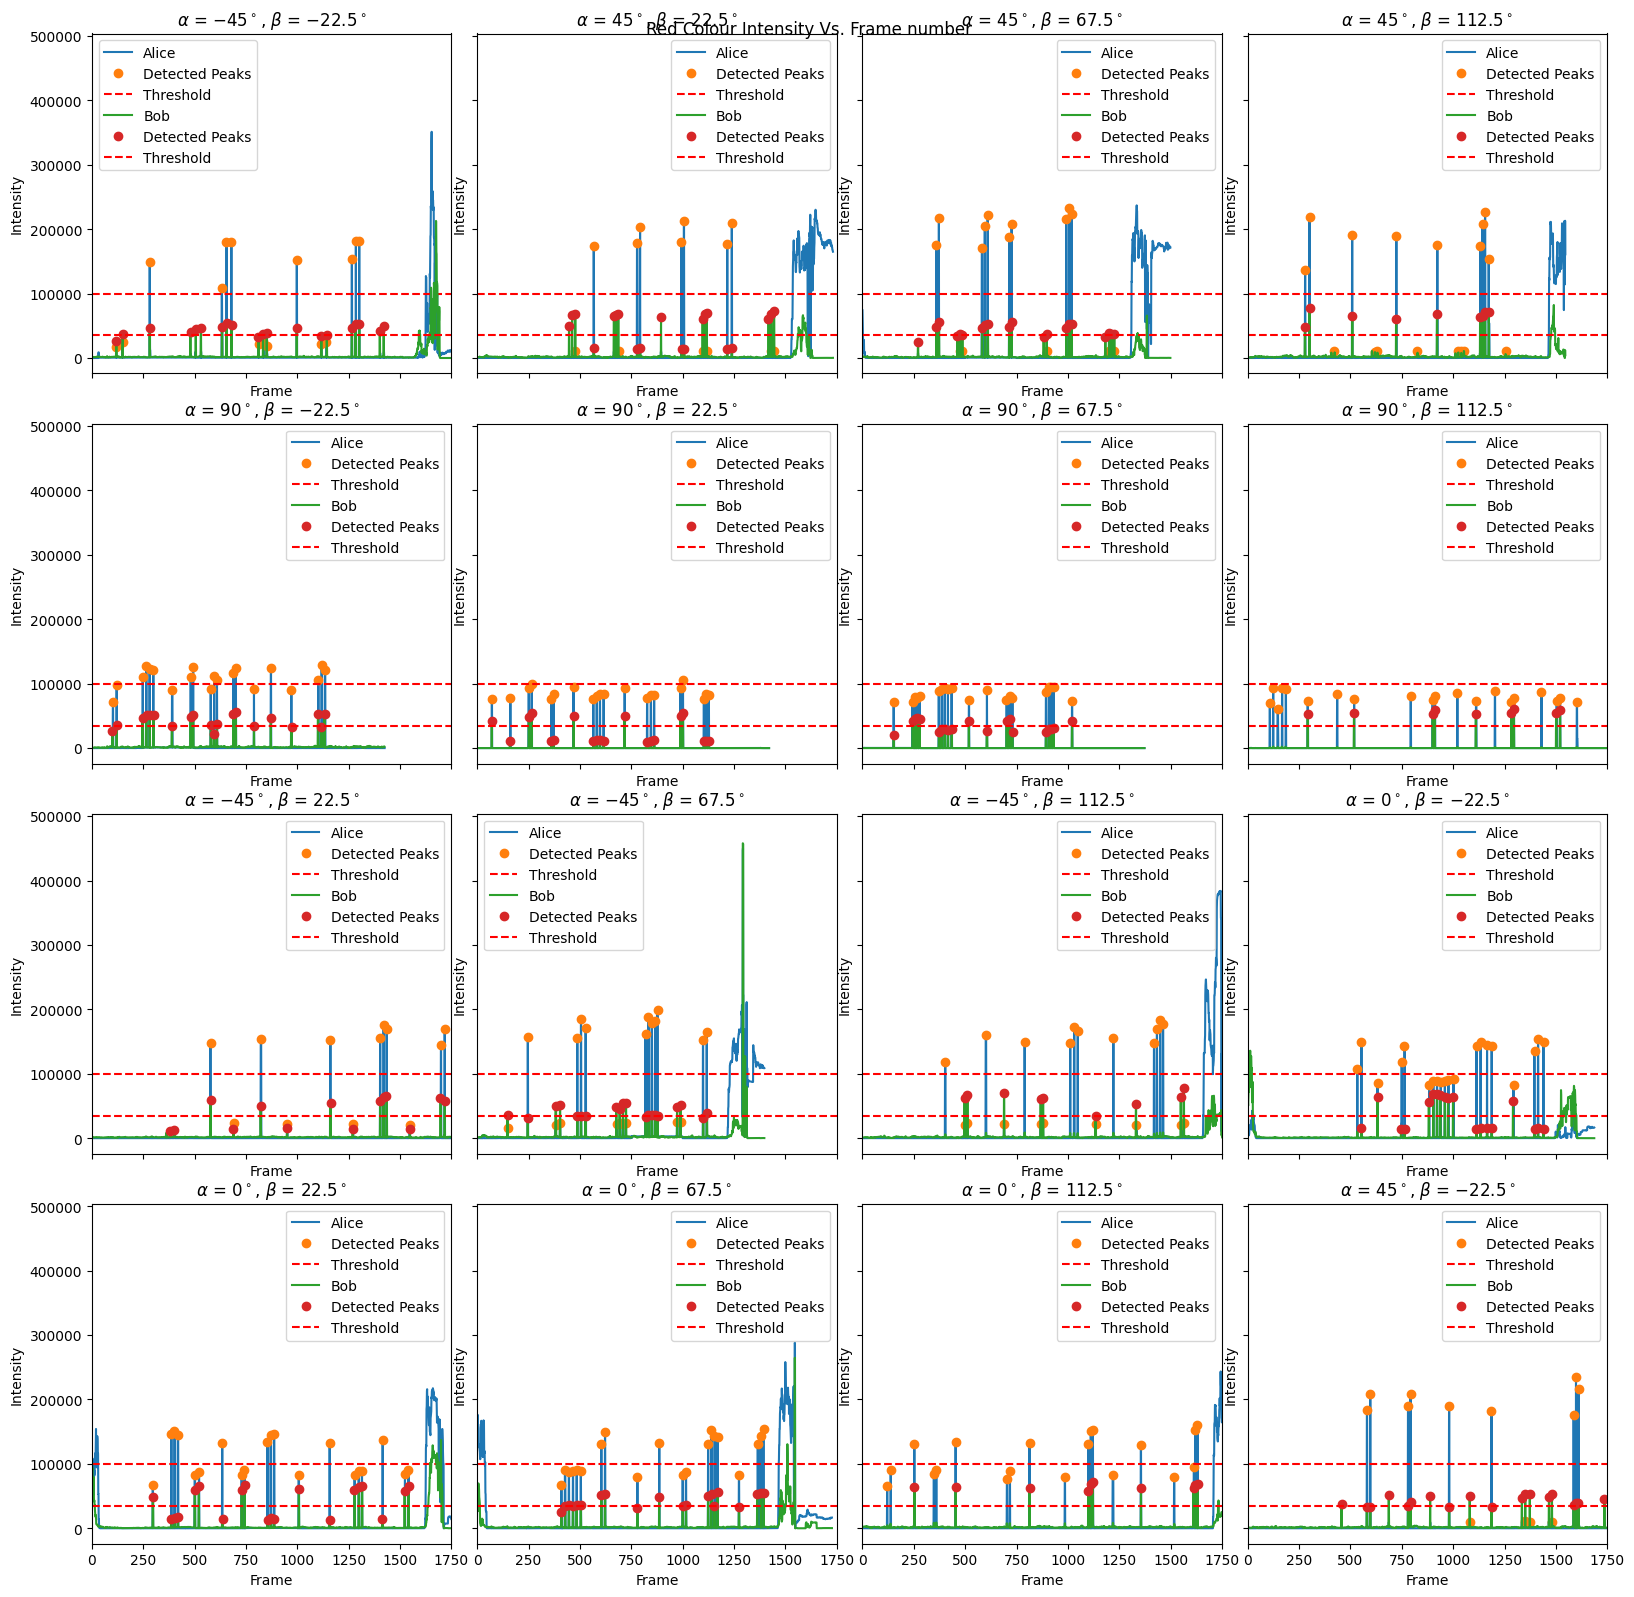

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


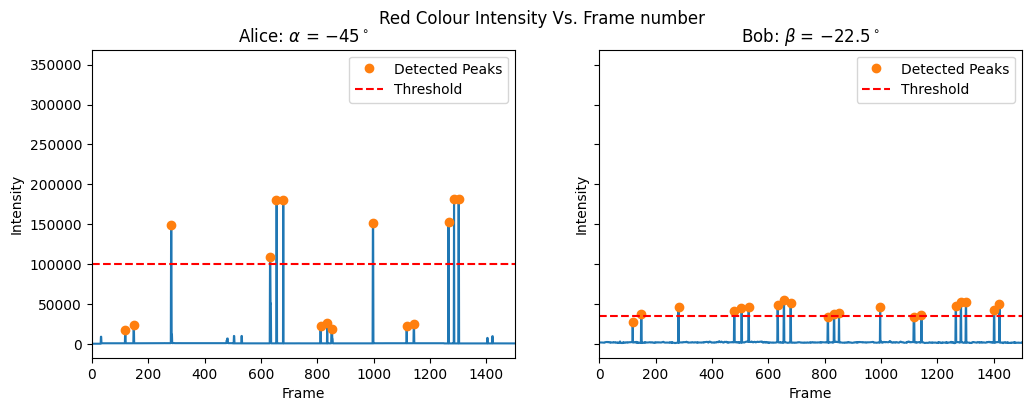

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


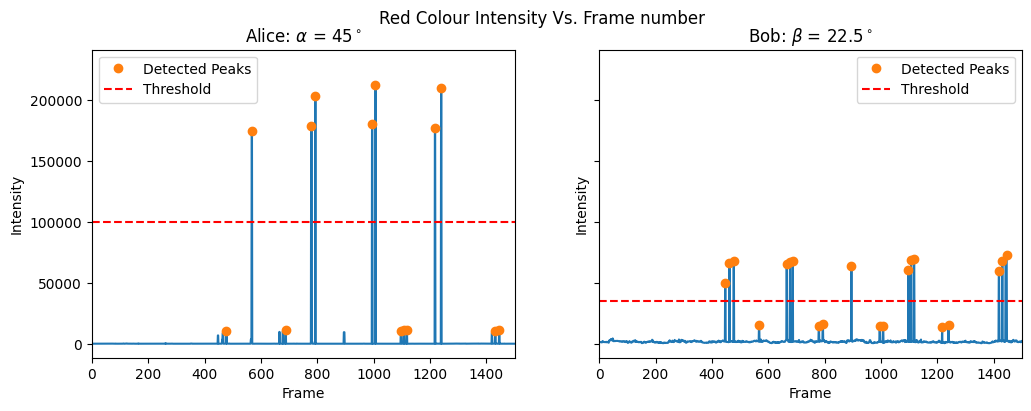

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


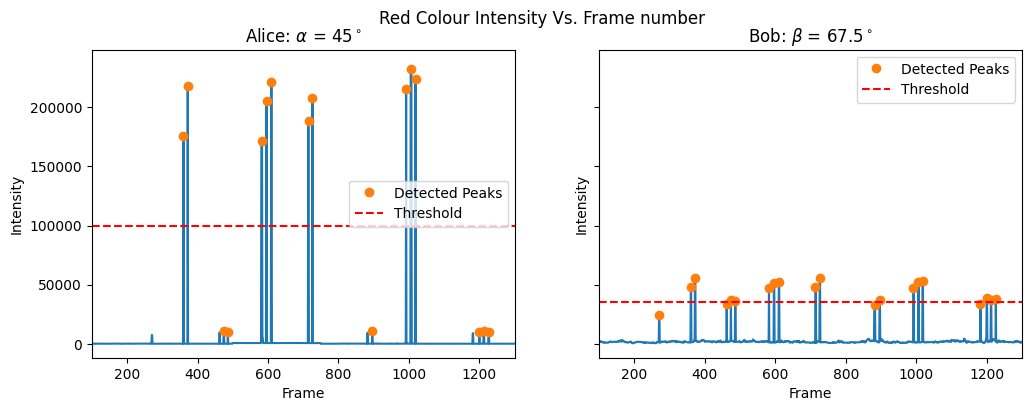

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


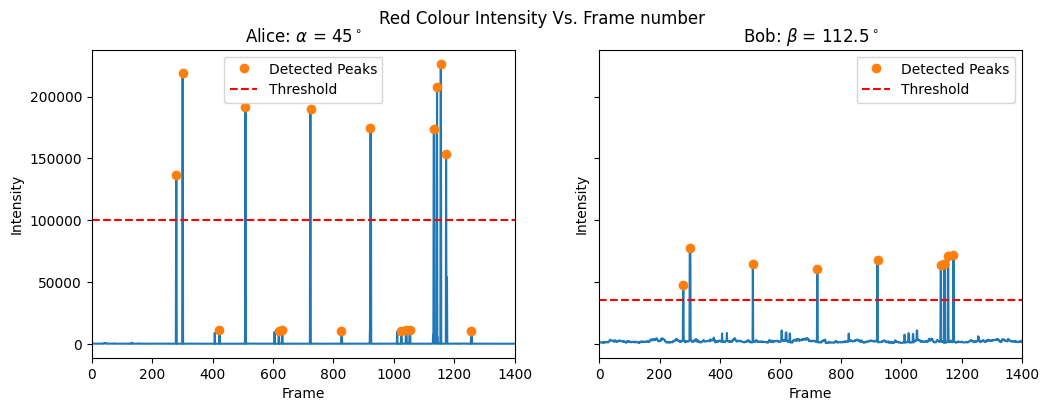

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


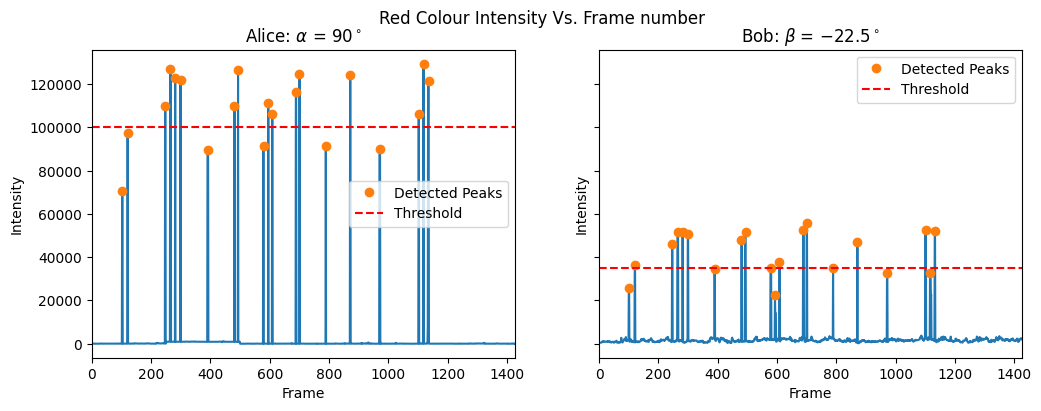

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


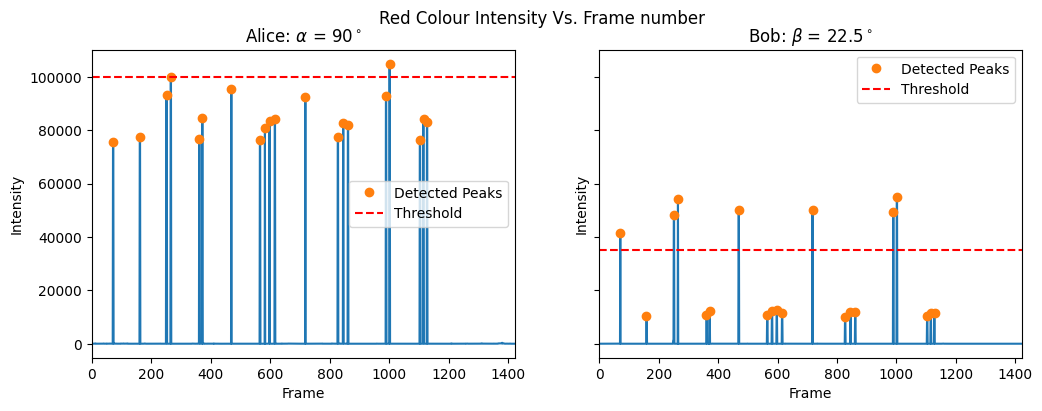

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


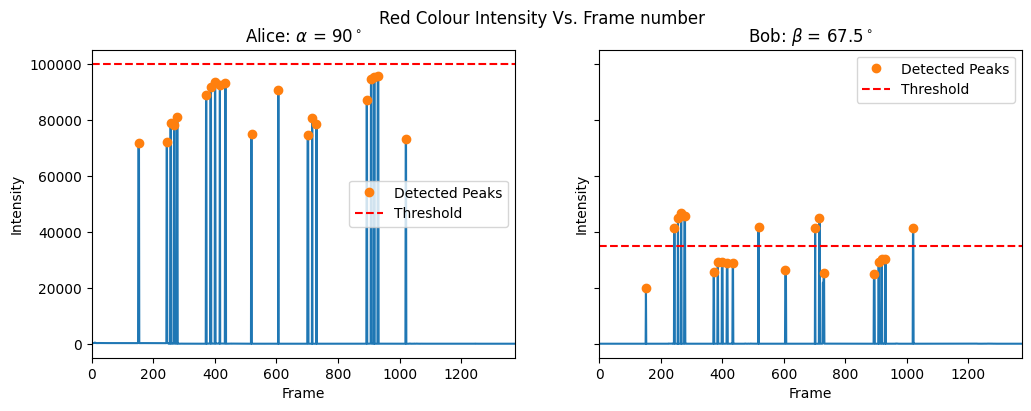

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


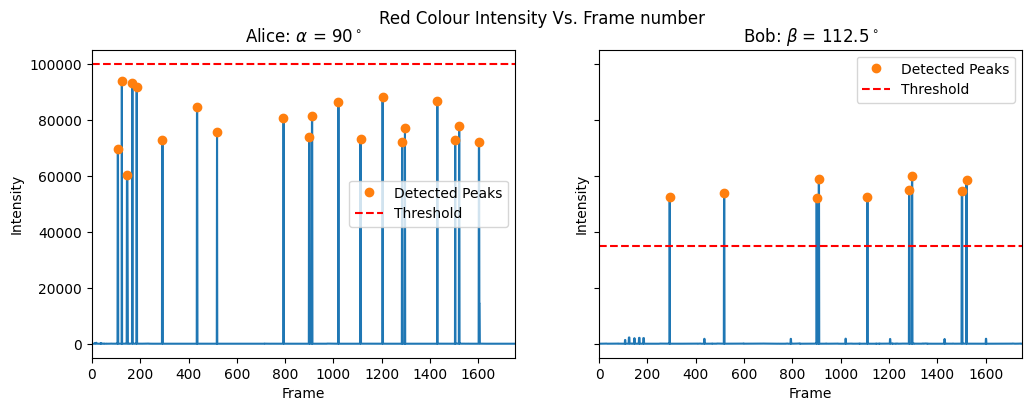

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


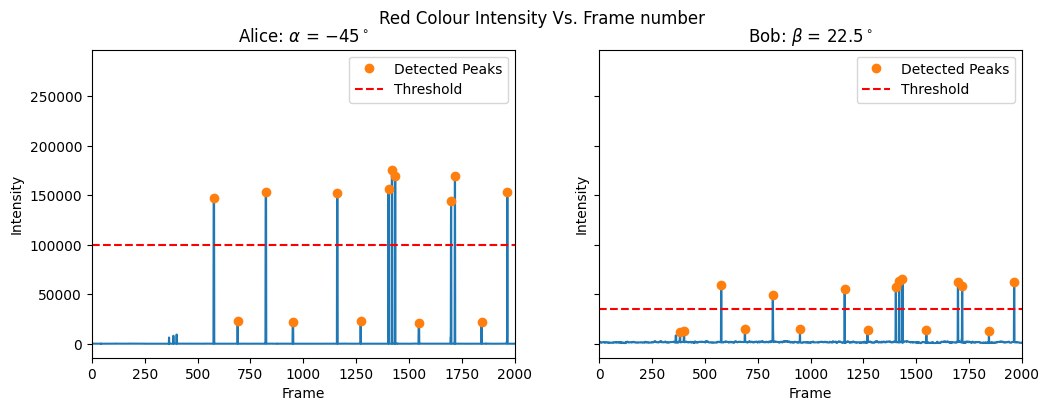

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


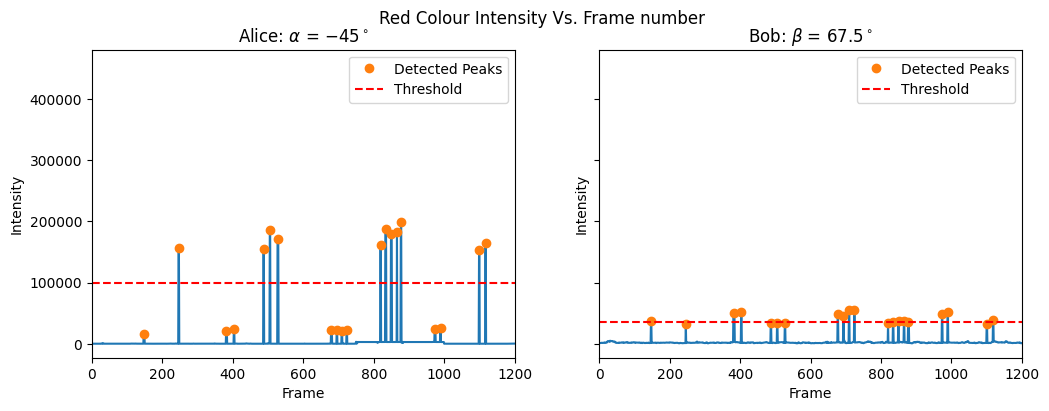

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


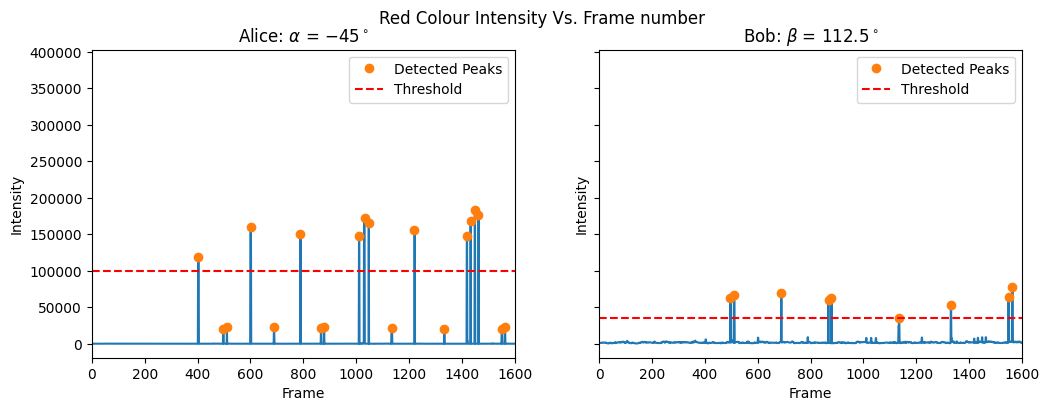

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


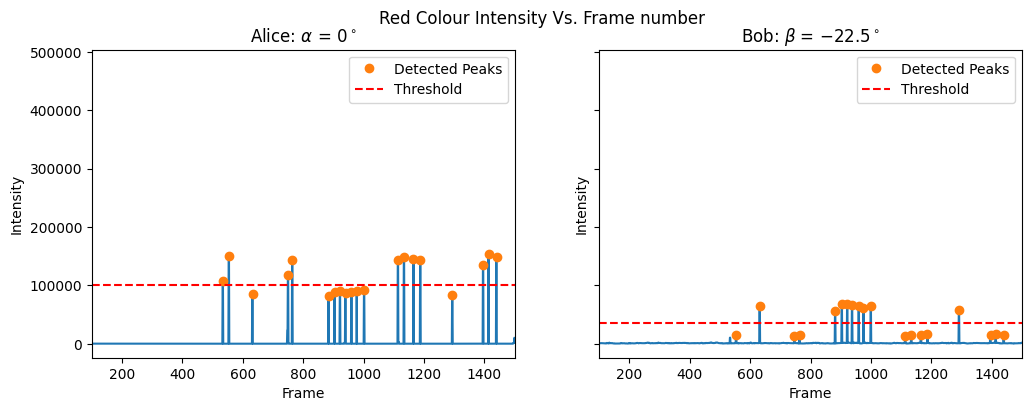

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


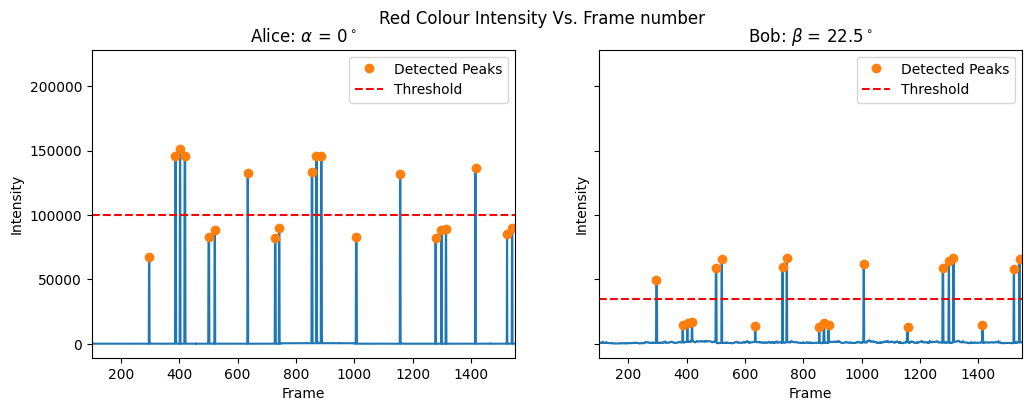

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


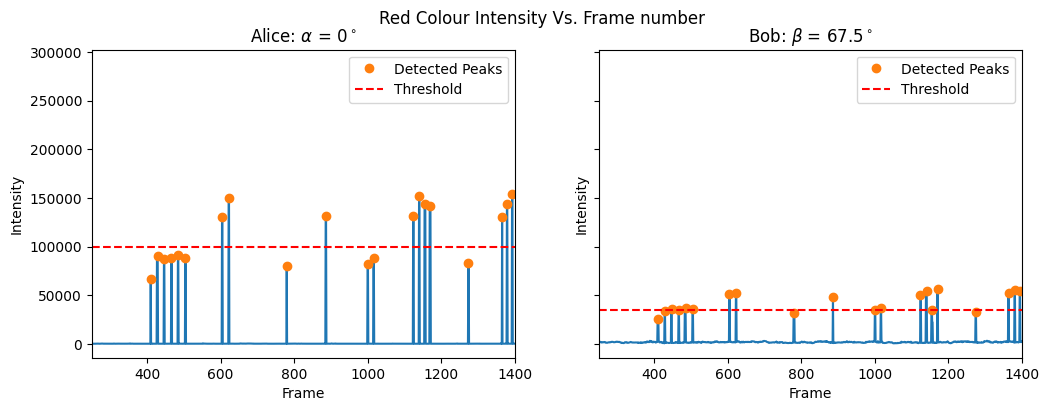

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


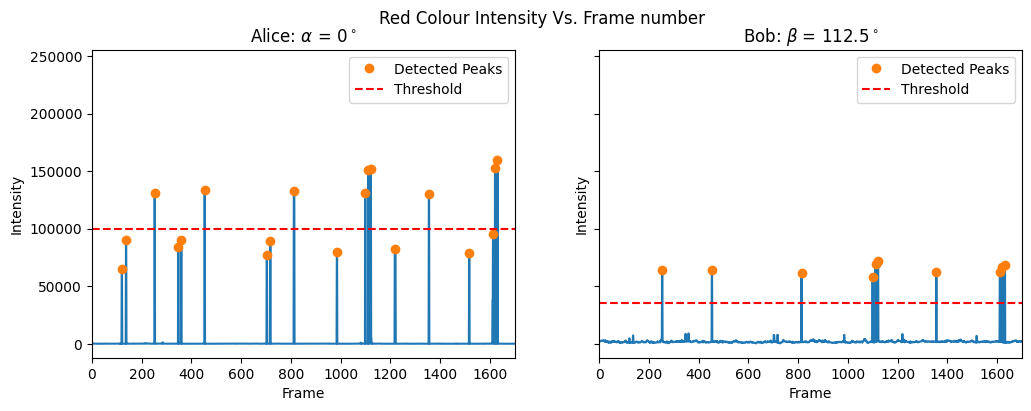

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


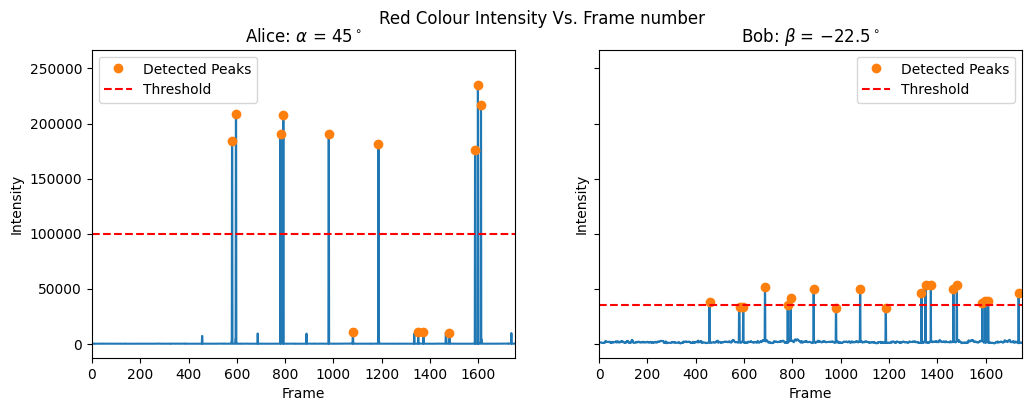

In [368]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp_signal

SENSOR_TO_THRESHOLD_BELL_PER_EXP = {
    Sensor.V_ALICE: 100000,
    Sensor.V_BOB: 35000,
}

file_name_to_frame_range = {
    "bell_1": (0, 1500), "bell_2": (0, 2000), "bell_3": (0, 1200), "bell_4": (0, 1600),
    "bell_5": (100, 1500), "bell_6": (100, 1550), "bell_7": (250, 1400), "bell_8": (0, 1700),
    "bell_9": (0, 1750), "bell_10": (0, 1500), "bell_11": (100, 1300), "bell_12": (0, 1400),
    "bell_13": (0, 10000), "bell_14": (0, 10000), "bell_15": (0, 10000), "bell_16": (0, 1750),
}

angles = [
    (-45, -22.5), (-45, 22.5), (-45, 67.5), (-45, 112.5),
    (0, -22.5), (0, 22.5), (0, 67.5), (0, 112.5),
    (45, -22.5), (45, 22.5), (45, 67.5), (45, 112.5),
    (90, -22.5), (90, 22.5), (90, 67.5), (90, 112.5)
]

bell_exps = {}
bell_exp_peaks_location = {}

# Create the original 4x4 subplot grid
fig, axes = plt.subplots(4, 4, figsize=(16, 16), sharex=True, sharey=True)
fig.suptitle("Red Colour Intensity Vs. Frame number")

sensor_pairs = {}

for (file_name, current_intensities), ax in zip(intensities.items(), axes.flatten()):
    angle_pair = angles[int(file_name.split("_")[-1]) - 1]
    if "bell" not in file_name:
        continue

    sensors = [sensor for sensor in current_intensities.keys() if sensor not in [Sensor.H_BOB, Sensor.H_ALICE]]
    if len(sensors) != 2:
        continue

    sensor_to_data = {}
    sensor_to_peaks_location = {}

    frame_range = file_name_to_frame_range.get(file_name, (0, 10000))
    for sensor in sensors:
        values = current_intensities[sensor]

        peaks, _ = sp_signal.find_peaks(values, prominence=10000, width=(None, 10), distance=5)
        peaks = [peak for peak in peaks if frame_range[0] < peak < frame_range[1]]

        peak_values = np.array(values)[peaks]
        threshold = SENSOR_TO_THRESHOLD_BELL_PER_EXP[sensor]

        sensor_to_data[sensor] = [int(peak > threshold) for peak in peak_values]
        sensor_to_peaks_location[sensor] = peaks

        ax.plot(np.arange(len(values)), values, label=f"{sensor.value.split()[0]}")
        ax.plot(peaks, np.array(values)[peaks], 'o', label="Detected Peaks")
        ax.axhline(y=threshold, color='r', linestyle='--', label='Threshold')

    ax.set_xbound(lower=frame_range[0], upper=min(frame_range[1], *[len(i) for i in current_intensities.values()]))
    ax.set_xlabel("Frame")
    ax.set_ylabel("Intensity")
    ax.legend()
    ax.set_title(f"$\\alpha$ = ${angle_pair[0]}^\\circ$, $\\beta$ = ${angle_pair[1]}^\\circ$")

    bell_exps[file_name] = sensor_to_data
    bell_exp_peaks_location[file_name] = sensor_to_peaks_location

    # Store sensor pair for additional subplots
    sensor_pair_key = tuple(sorted(sensors, key=lambda s: s.value))
    if sensor_pair_key not in sensor_pairs:
        sensor_pairs[sensor_pair_key] = []
    sensor_pairs[sensor_pair_key].append((file_name, current_intensities, frame_range))

plt.tight_layout(pad=0.1)  # Adjust layout to fit title
plt.savefig(f"./all_bell.eps")
plt.show()

for sensor_pair, experiments in sensor_pairs.items():
    for file_name, current_intensities, frame_range in experiments:
        angle_pair = angles[int(file_name.split("_")[-1]) - 1]
        fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
        fig.suptitle("Red Colour Intensity Vs. Frame number")
        for sensor, ax in zip(sensor_pair, axs):
            values = current_intensities[sensor]
            peaks, _ = sp_signal.find_peaks(values, prominence=10000, width=(None, 10), distance=5)
            peaks = [peak for peak in peaks if frame_range[0] < peak < frame_range[1]]
            threshold = SENSOR_TO_THRESHOLD_BELL_PER_EXP[sensor]
            
            ax.plot(np.arange(len(values)), values)
            ax.plot(peaks, np.array(values)[peaks], 'o', label="Detected Peaks")
            ax.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
            
            angle_value = angle_pair[0] if sensor == Sensor.V_ALICE else angle_pair[1]
            angle_latex = "\\alpha" if sensor == Sensor.V_ALICE else "\\beta"
            ax.set_xbound(lower=frame_range[0],
                          upper=min(frame_range[1], *[len(i) for i in current_intensities.values()]))
            ax.set_xlabel("Frame")
            ax.set_ylabel("Intensity")
            ax.legend()
            ax.set_title(f"{sensor.value.split()[0]}: ${angle_latex}$ = ${angle_value}^\\circ$")
        
        fig.savefig(f"./{file_name}.eps")
        plt.show()


# Calculating Bell's inequality
input: peaks of bell test measurements

output: S parameter of the bell test


In [369]:
from uncertainties import ufloat

alpha_beta_to_N = {}

for i, current_angles in zip(range(1, 16 + 1), angles):
    exp_is_peaks = bell_exps[f"bell_{i}"]
    exp_peak_locations = bell_exp_peaks_location[f"bell_{i}"]

    v_bob_peak_locations = [x for is_peak, x in zip(exp_is_peaks[Sensor.V_BOB], exp_peak_locations[Sensor.V_BOB])
                            if
                            is_peak]
    v_alice_peak_locations = [x for is_peak, x in
                              zip(exp_is_peaks[Sensor.V_ALICE], exp_peak_locations[Sensor.V_ALICE])
                              if is_peak]

    N = 0
    for bob_peak_x in v_bob_peak_locations:
        for alice_peak_x in v_alice_peak_locations:
            if abs(bob_peak_x - alice_peak_x) < 3:
                N += 1
    print(f"{current_angles} - {N}")
    alpha_beta_to_N[current_angles] = ufloat(N, N ** 0.5)


def get_perp_beta(beta):
    pairs = [(-22.5, 67.5), (22.5, 112.5)]

    for pair in pairs:
        if np.isclose(beta, pair[0]):
            return pair[1]
        elif np.isclose(beta, pair[1]):
            return pair[0]

    raise ValueError(f"Angle {beta} not found in defined pairs.")


def get_perp_alpha(alpha):
    pairs = [(-45, 45), (0, 90)]
    for pair in pairs:
        if np.isclose(alpha, pair[0]):
            return pair[1]
        elif np.isclose(alpha, pair[1]):
            return pair[0]

    raise ValueError(f"Angle {alpha} not found in defined pairs.")


def compute_E(N, alpha, beta):
    return (N[(alpha, beta)] + N[(get_perp_alpha(alpha), get_perp_beta(beta))] - N[(alpha, get_perp_beta(beta))] - N[
        (get_perp_alpha(alpha), beta)]) / (
            N[(alpha, beta)] + N[(get_perp_alpha(alpha), get_perp_beta(beta))] + N[(alpha, get_perp_beta(beta))] +
            N[(get_perp_alpha(alpha), beta)])


a = 0
a_tag = 45
b = 22.5
b_tag = 67.5

S = (compute_E(alpha_beta_to_N, a, b) - compute_E(alpha_beta_to_N, a, b_tag) + compute_E(alpha_beta_to_N, a_tag, b) +
     compute_E(
         alpha_beta_to_N, a_tag, b_tag))
print(S)

(-45, -22.5) - 8
(-45, 22.5) - 8
(-45, 67.5) - 5
(-45, 112.5) - 0
(0, -22.5) - 0
(0, 22.5) - 0
(0, 67.5) - 9
(0, 112.5) - 9
(45, -22.5) - 5
(45, 22.5) - 0
(45, 67.5) - 10
(45, 112.5) - 9
(90, -22.5) - 11
(90, 22.5) - 1
(90, 67.5) - 0
(90, 112.5) - 0
-2.71+/-0.18


# Density Matrix Simulation
output: density matrices calculated using a virtual experiment for the first and third bell states

In [370]:
import itertools

import numpy as np
import qutip as qt

# Define basis states
H = qt.basis(2, 0)  # Horizontal polarization |H>
V = qt.basis(2, 1)  # Vertical polarization |V>

# Define measurement bases
D = (H + V).unit()  # Diagonal |D>
A = (H - V).unit()  # Anti-diagonal |A>
R = (H - 1j * V).unit()  # Right circular |R>
L = (H + 1j * V).unit()  # Left circular |L>

bases = [H, V, D, A, R, L]

def get_psi():
    return (V + H) / np.sqrt(2)


# Compute the true density matrix
rho_true = get_psi() * get_psi().dag()

# Define Pauli matrices and Identity
sigma_0 = qt.qeye(2)
sigma_x = qt.sigmax()
sigma_y = qt.sigmay()
sigma_z = qt.sigmaz()


for num_photons in (10, 100, 1000):
    # Number of simulated photons
    n_s = np.zeros(4)

    base_to_count = np.zeros(len(bases))

    for i in range(num_photons):
        psi = get_psi()
        for j, base in enumerate(bases):
            m, _ = qt.measurement.measure(psi, base * base.dag())
            if m:
                base_to_count[j] += 1

    n_s[0] = base_to_count[bases.index(H)] + base_to_count[bases.index(V)]
    n_s[1] = base_to_count[bases.index(D)] - base_to_count[bases.index(A)]
    n_s[2] = base_to_count[bases.index(L)] - base_to_count[bases.index(R)]
    n_s[3] = base_to_count[bases.index(H)] - base_to_count[bases.index(V)]

    # # Compute Stokes parameters
    S = n_s
    S /= S[0]

    # Reconstruct the density matrix
    rho_reconstructed = 0.5 * (np.dot(np.array([sigma_0, sigma_x, sigma_y, sigma_z]), S))
    print(f"Number of photons: {num_photons}")
    
    print("Single Qbit calculated density matrix")
    print(rho_true)
    print("Reconstructed Qbit density matrix")
    print(rho_reconstructed)

    # Convert to analogs qbit pair first bell state
    mat_first_bell = np.zeros((4, 4))
    for x, y in itertools.product([0, -1], repeat=2):
        mat_first_bell[x, y] = rho_reconstructed[x, y]

    print("Reconstructed Qbit density matrix - modified to be qbit pair for first bell state")
    print(bmatrix(mat_first_bell))
    
    mat_third_bell = np.zeros((4, 4))
    
    mat_third_bell[1, 1] = mat_first_bell[0, 0]
    mat_third_bell[2, 1] = mat_first_bell[3, 0]
    mat_third_bell[1, 2] = mat_first_bell[0, 3]
    mat_third_bell[2, 2] = mat_first_bell[3, 3]


    print("Reconstructed Qbit density matrix - modified to be qbit pair for third bell state")
    print(bmatrix(mat_third_bell))

Number of photons: 10
Single Qbit calculated density matrix
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.5 0.5]
 [0.5 0.5]]
Reconstructed Qbit density matrix
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.55555556+0.j         0.55555556+0.05555556j]
 [0.55555556-0.05555556j 0.44444444+0.j        ]]
Reconstructed Qbit density matrix - modified to be qbit pair for first bell state
\begin{bmatrix}
  0.55555556 & 0. & 0. & 0.55555556\\
  0. & 0. & 0. & 0.\\
  0. & 0. & 0. & 0.\\
  0.55555556 & 0. & 0. & 0.44444444\\
\end{bmatrix}
Reconstructed Qbit density matrix - modified to be qbit pair for third bell state
\begin{bmatrix}
  0. & 0. & 0. & 0.\\
  0. & 0.55555556 & 0.55555556 & 0.\\
  0. & 0.55555556 & 0.44444444 & 0.\\
  0. & 0. & 0. & 0.\\
\end{bmatrix}
Number of photons: 100
Single Qbit calculated density matrix
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=D

C:\Users\30109\AppData\Local\Temp\ipykernel_65068\595966595.py:66: ComplexWarning: Casting complex values to real discards the imaginary part
  mat_first_bell[x, y] = rho_reconstructed[x, y]


Number of photons: 1000
Single Qbit calculated density matrix
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.5 0.5]
 [0.5 0.5]]
Reconstructed Qbit density matrix
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.48672566+0.j         0.49164208-0.01179941j]
 [0.49164208+0.01179941j 0.51327434+0.j        ]]
Reconstructed Qbit density matrix - modified to be qbit pair for first bell state
\begin{bmatrix}
  0.48672566 & 0. & 0. & 0.49164208\\
  0. & 0. & 0. & 0.\\
  0. & 0. & 0. & 0.\\
  0.49164208 & 0. & 0. & 0.51327434\\
\end{bmatrix}
Reconstructed Qbit density matrix - modified to be qbit pair for third bell state
\begin{bmatrix}
  0. & 0. & 0. & 0.\\
  0. & 0.48672566 & 0.49164208 & 0.\\
  0. & 0.49164208 & 0.51327434 & 0.\\
  0. & 0. & 0. & 0.\\
\end{bmatrix}
